# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

**Цель работы:** построить модель, классифицирующую комментарии на позитивные и негативные.

## Подготовка

Импортируем необходимые в работе библиотеки.

In [1]:
import pandas as pd
import re 
from sklearn.model_selection import train_test_split
import nltk
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords as nltk_stopwords 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostRegressor
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.metrics import f1_score

Загрузим и изучим предоставленные данные.

In [2]:
data = pd.read_csv('/datasets/toxic_comments.csv', index_col=0)
data.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


Проверим данные на наличие пропусков и дубликатов.

In [4]:
data.isna().sum()

text     0
toxic    0
dtype: int64

In [5]:
data.duplicated().sum()

0

Пропуски и явные дубликаты отсутствуют. Проверим баланс классов целевого признака.

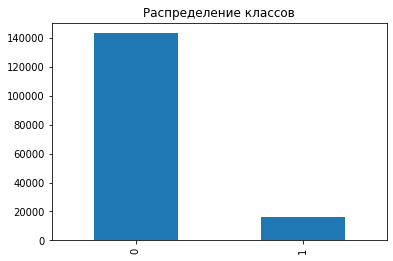

In [6]:
data['toxic'].value_counts().plot(kind='bar', title='Распределение классов');

Очевидно превосходство класса 0.

Напишем функции для лемматизации и очистки текста от лишних символов.

In [7]:
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()
def lemmatize(text):
    word_list = nltk.word_tokenize(text)
    lemm_list = [lemmatizer.lemmatize(word) for word in word_list]
    lemm_text = " ".join(lemm_list)
    return lemm_text

[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [8]:
def clear_text(text):
    return " ".join(re.sub(r'[^a-zA-Z]', ' ', text).split())

In [9]:
corpus = data['text'].values
data['lemm_text'] = [lemmatize(clear_text(corpus[i])) for i in range(len(corpus))]
data.head()

,text,toxic,lemm_text
0,Explanation\nWhy the edits made under my usern...,0,Explanation Why the edits made under my userna...
1,D'aww! He matches this background colour I'm s...,0,D aww He match this background colour I m seem...
2,"Hey man, I'm really not trying to edit war. It...",0,Hey man I m really not trying to edit war It s...
3,"""\nMore\nI can't make any real suggestions on ...",0,More I can t make any real suggestion on impro...
4,"You, sir, are my hero. Any chance you remember...",0,You sir are my hero Any chance you remember wh...


Разделим данные на обучающую и тестовую выборки.

In [10]:
features = data['lemm_text']
target = data['toxic']
X_train, X_test, y_train, y_test = train_test_split(features, 
                                                    target, 
                                                    test_size=0.25,
                                                    random_state=12345)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(119469,) (39823,) (119469,) (39823,)


Переведем тексты в векторный формат.

In [11]:
nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))
count_tf_idf = TfidfVectorizer(stop_words=stopwords)
X_train = count_tf_idf.fit_transform(X_train)
X_test = count_tf_idf.transform(X_test)

print(X_train.shape, X_test.shape)

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


(119469, 137912) (39823, 137912)


## Обучение

Обучим несколько моделей и сравним их показатели F1-меры.

### Логистическая регрессия

In [12]:
model_lr = LogisticRegression(random_state=12345, solver='liblinear', max_iter=1000)

param = {'C': range(1,11,1)}
grid = RandomizedSearchCV(model_lr, param, n_iter=5, scoring='f1')
grid.fit(X_train, y_train)
best_model_lr = grid.best_estimator_
f1_lr = grid.best_score_
print('F1:', f1_lr, 'Параметры:', grid.best_params_)

F1: 0.7589746420957431 Параметры: {'C': 10}


### Дерево решений

In [13]:
model_dt = DecisionTreeClassifier(random_state=12345)

param = {'max_depth': range(1,21,1)}
grid = RandomizedSearchCV(model_dt, param, n_iter=5, scoring='f1')
grid.fit(X_train, y_train)
best_model_dt = grid.best_estimator_
f1_dt = grid.best_score_
print('F1:', f1_dt, 'Параметры:', grid.best_params_)

F1: 0.644800376637028 Параметры: {'max_depth': 20}


### Случайный лес

In [14]:
model_rf = RandomForestClassifier(random_state=12345)

param = {'max_depth': range(1,11,1),
         'n_estimators':range(10,50,10)}
grid = RandomizedSearchCV(model_rf, param, n_iter=5, scoring='f1')
grid.fit(X_train, y_train)
best_model_rf = grid.best_estimator_
f1_rf = grid.best_score_
print('F1:', f1_rf, 'Параметры:', grid.best_params_)

F1: 0.0 Параметры: {'n_estimators': 20, 'max_depth': 3}


Лучший результат показала модель логистической регрессии, проверим ее на тестовой выборке.

In [15]:
predictions = best_model_lr.predict(X_test)
f1_score(y_test, predictions)

0.7801221543586897

## Выводы

В ходе данной работы были изучены предоставленные данные, тексты были лемматизированы, очищены от лишних символов и переведены в векторный формат. Были обучены несколько моделей, классифицирующих комментарии, лучший результат показала модель логистической регресcии(C=10, solver='liblinear', max_iter=1000), значение F1-меры на тестовой выборке 0.78.